In [8]:
import numpy as np
import h5py
import pickle
from pathlib import Path

from pathlib import Path
import sys

# Add repo paths so empca modules and pickled models can be imported
def _repo_root():
    here = Path.cwd().resolve()
    if (here / 'wk2').exists() and (here / 'reusable').exists():
        return here
    return here.parent

repo = _repo_root()
sys.path.insert(0, str(repo / 'reusable'))
sys.path.insert(0, str(repo / 'wk2' / 'training'))
from empca_TCY_optimized import ti_rfft


In [9]:
import numpy as np
import h5py
import pickle
from numpy.lib import recfunctions as rfn
from pathlib import Path

from pathlib import Path
import sys

# Add repo paths so empca modules and pickled models can be imported
def _repo_root():
    here = Path.cwd().resolve()
    if (here / 'wk2').exists() and (here / 'reusable').exists():
        return here
    return here.parent

repo = _repo_root()
sys.path.insert(0, str(repo / 'reusable'))
sys.path.insert(0, str(repo / 'wk2' / 'training'))
from empca_TCY_optimized import ti_rfft


def baseline_correct_per_trace(X_time, pretrigger=4000, method="mean"):
    X_time = np.asarray(X_time, dtype=np.float64)
    if X_time.ndim != 2:
        raise ValueError(f"X_time must be 2D; got {X_time.shape}")
    if not (1 <= pretrigger <= X_time.shape[1]):
        raise ValueError("pretrigger must be within [1, n_time]")

    pre = X_time[:, :pretrigger]
    if method == "mean":
        baseline = np.mean(pre, axis=1)
    elif method == "median":
        baseline = np.median(pre, axis=1)
    else:
        raise ValueError("method must be 'mean' or 'median'")

    X0 = X_time - baseline[:, None]
    return X0, baseline


def to_shift_invariant_spectrum(X_time):
    X_tilde = ti_rfft(X_time)
    if X_tilde.ndim != 2:
        raise RuntimeError("Unexpected output shape from ti_rfft")
    return X_tilde


def make_inverse_psd_weights(noise_psd, eps=1e-18):
    noise_psd = np.asarray(noise_psd, dtype=np.float64)
    if noise_psd.ndim != 1:
        raise ValueError(f"noise_psd must be 1D; got {noise_psd.shape}")
    return 1.0 / (noise_psd + eps)


def project_coefficients(X_feat, eigvec, inv_psd):
    Phi = eigvec.T  # (n_freq, n_comp)
    WPhi = Phi * inv_psd[:, None]
    A = Phi.conj().T @ WPhi
    rhs = (X_feat * inv_psd[None, :]) @ Phi.conj()
    coeff = np.linalg.solve(A, rhs.T).T
    return coeff


def pca_amplitude_estimator(coeff):
    coeff = np.asarray(coeff)
    return np.sqrt(np.sum(np.abs(coeff) ** 2, axis=1))


def linear_calibrate(x, y):
    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()
    M = np.vstack([x, np.ones_like(x)]).T
    a, b = np.linalg.lstsq(M, y, rcond=None)[0]
    return a, b


def apply_calibration(x, a, b):
    return a * np.asarray(x) + b


def resolution_from_truth(E_est, E_true):
    resid = np.asarray(E_true) - np.asarray(E_est)
    sigma = np.std(resid, ddof=1)
    fwhm = 2.355 * sigma
    return sigma, fwhm


def robust_sigma(x):
    x = np.asarray(x)
    med = np.median(x)
    mad = np.median(np.abs(x - med))
    return 1.4826 * mad


def resolution_from_line(E_est):
    sigma = robust_sigma(E_est)
    fwhm = 2.355 * sigma
    return sigma, fwhm


In [10]:
# Load clean + noisy traces (pair qp sum, energy 500)
from pathlib import Path
import re
import numpy as np
import h5py

OUTDIR = Path('/ceph/dwong/trigger_samples/PCA_QP')
ENERGY_EV = 500
N_BATCHES = None  # use all available when None

def _batch_id(path: Path) -> int:
    m = re.search(r'_batch_(\d+)', path.name)
    if not m:
        raise ValueError(f'Could not parse batch id from {path.name}')
    return int(m.group(1))

pattern = f'NR_traces_energy_{ENERGY_EV}_pair_qp_sum_batch_*.h5'
files = sorted(OUTDIR.glob(pattern), key=_batch_id)
if N_BATCHES is not None:
    if len(files) < N_BATCHES:
        raise FileNotFoundError(f'Found {len(files)} batches; expected at least {N_BATCHES}.')
    files = files[:N_BATCHES]

noisy_list = []
clean_list = []
for p in files:
    with h5py.File(p, 'r') as f:
        noisy_list.append(f['traces'][:].astype(np.float64))
        clean_list.append(f['traces_clean'][:].astype(np.float64))

traces_noisy = np.concatenate(noisy_list, axis=0)[:, 0, :]
traces_clean = np.concatenate(clean_list, axis=0)[:, 0, :]

print('loaded batches:', len(files))
print('noisy shape:', traces_noisy.shape)
print('clean shape:', traces_clean.shape)


loaded batches: 10
noisy shape: (1000, 32768)
clean shape: (1000, 32768)


In [11]:
# True amplitude from clean summed traces (max value per trace)
A_true = np.max(traces_clean, axis=1)
print('A_true shape:', A_true.shape)
print('A_true stats: min/mean/max =', np.min(A_true), np.mean(A_true), np.max(A_true))


A_true shape: (1000,)
A_true stats: min/mean/max = 149.6131591796875 395.7624611053467 557.0384521484375


In [12]:
# Load trained EMPCA models (sum-channel)
from pathlib import Path
import pickle

repo = _repo_root()
model_psd_path = repo / 'PSD_run1_sum.pkl'
model_snr_path = repo / 'SNR2_run1_sum.pkl'

with open(model_psd_path, 'rb') as f:
    model_psd = pickle.load(f)

with open(model_snr_path, 'rb') as f:
    model_snr = pickle.load(f)

print('loaded models:', model_psd_path, model_snr_path)


loaded models: /home/dwong/DELight_mtr/PCA_dev/PSD_run1_sum.pkl /home/dwong/DELight_mtr/PCA_dev/SNR2_run1_sum.pkl


In [13]:
# Evaluate EMPCA amplitude for both models using paper-style projection
def get_weight_vector(model_artifact):
    if 'psd_eff' in model_artifact and model_artifact['psd_eff'] is not None:
        psd_eff = np.asarray(model_artifact['psd_eff'], dtype=np.float64)
        return 1.0 / (psd_eff + 0.0)
    if 'psd_path' in model_artifact and model_artifact['psd_path']:
        psd_arr = np.load(model_artifact['psd_path'])
        psd = psd_arr[1] if psd_arr.ndim == 2 and psd_arr.shape[0] == 2 else psd_arr
        return 1.0 / (psd.astype(np.float64) + 0.0)
    if 'snr2_weight_path' in model_artifact and model_artifact['snr2_weight_path']:
        return np.load(model_artifact['snr2_weight_path']).astype(np.float64)
    raise ValueError('No recognized weight info in model artifact')

def compute_amp_for_model(model_artifact, X_time, use_shift_invariant=True):
    pca = model_artifact['pca']
    cfg = model_artifact.get('cfg', {})
    pretrigger = cfg.get('pretrigger', 4000)
    baseline_method = cfg.get('baseline_method', 'mean')

    X0, _ = baseline_correct_per_trace(X_time, pretrigger=pretrigger, method=baseline_method)
    if use_shift_invariant:
        X_feat = to_shift_invariant_spectrum(X0)
    else:
        X_feat = np.fft.rfft(X0, axis=-1)

    eigvec = pca.eigvec
    n_freq = eigvec.shape[1]
    if X_feat.shape[1] != n_freq:
        raise ValueError(f'Frequency bins mismatch: {X_feat.shape[1]} vs {n_freq}')

    w = get_weight_vector(model_artifact)
    coeff = project_coefficients(X_feat, eigvec, w)
    amp_raw = pca_amplitude_estimator(coeff)
    return amp_raw, coeff

# Apply keep_mask if present and compatible
keep_mask = model_psd.get('keep_mask')
if keep_mask is not None and len(keep_mask) == len(traces_noisy):
    X_eval = traces_noisy[keep_mask]
    A_true_eval = A_true[keep_mask]
else:
    X_eval = traces_noisy
    A_true_eval = A_true

amp_psd, _ = compute_amp_for_model(model_psd, X_eval)
amp_snr, _ = compute_amp_for_model(model_snr, X_eval)

# Linear calibration: A_true ≈ a * amp + b
a_psd, b_psd = linear_calibrate(amp_psd, A_true_eval)
A_psd_est = apply_calibration(amp_psd, a_psd, b_psd)

a_snr, b_snr = linear_calibrate(amp_snr, A_true_eval)
A_snr_est = apply_calibration(amp_snr, a_snr, b_snr)

sigma_psd, fwhm_psd = resolution_from_truth(A_psd_est, A_true_eval)
sigma_snr, fwhm_snr = resolution_from_truth(A_snr_est, A_true_eval)

print('[PSD]  calib a,b:', a_psd, b_psd)
print('[PSD]  sigma/FWHM:', sigma_psd, fwhm_psd)
print('[SNR2] calib a,b:', a_snr, b_snr)
print('[SNR2] sigma/FWHM:', sigma_snr, fwhm_snr)


[PSD]  calib a,b: 6.184675994118087e-05 66.45412138776946
[PSD]  sigma/FWHM: 29.62645959259795 69.77031234056817
[SNR2] calib a,b: 1.0706586751210187e-06 139.97809731819473
[SNR2] sigma/FWHM: 40.12968686252122 94.50541256123746


In [24]:
# Optimum Filter (OF) amplitude on noisy sum traces
import numpy as np
from OptimumFilter import OptimumFilter
from pathlib import Path

repo = _repo_root()
template_path = repo / 'reusable' / 'QP_template.npy'
template = np.load(template_path).astype(np.float64).squeeze()

# Use same PSD as training (one-sided)
psd_path = Path('/ceph/dwong/delight/noise_psd_xray.npy')
psd_arr = np.load(psd_path)
psd = psd_arr[1] if psd_arr.ndim == 2 and psd_arr.shape[0] == 2 else psd_arr
psd = psd.astype(np.float64)

# Sampling frequency (from reusable/PCA_config.yaml)
fs = 3906250.0

if template.ndim != 1:
    raise ValueError(f'Template must be 1D; got shape {template.shape}')

# Baseline subtraction (same as EMPCA)
pretrigger = model_psd.get('cfg', {}).get('pretrigger', 4000)
template0 = template - np.mean(template[:pretrigger])

X0, _ = baseline_correct_per_trace(X_eval, pretrigger=pretrigger, method='mean')

if template.shape[0] != X0.shape[1]:
    raise ValueError(f'Template length {template.shape[0]} != trace length {X0.shape[1]}')

# OF fit per trace
of = OptimumFilter(template0, psd, fs)
amp_of = np.empty(X0.shape[0], dtype=np.float64)
for i in range(X0.shape[0]):
    amp, _ = of.fit(X0[i])
    amp_of[i] = amp

# Linear calibration: A_true ≈ a * amp + b
A = np.vstack([amp_of, np.ones_like(amp_of)]).T
a_of, b_of = np.linalg.lstsq(A, A_true_eval, rcond=None)[0]
A_of_est = a_of * amp_of + b_of

sigma_of, fwhm_of = resolution_from_truth(A_of_est, A_true_eval)

print('[OF]   calib a,b:', a_of, b_of)
print('[OF]   sigma/FWHM:', sigma_of, fwhm_of)
print('--- comparison (sigma/FWHM) ---')
print('PCA-PSD :', sigma_psd, fwhm_psd)
print('PCA-SNR2:', sigma_snr, fwhm_snr)
print('OF      :', sigma_of, fwhm_of)


[OF]   calib a,b: 1.1002189981401334 1.526599066432549
[OF]   sigma/FWHM: 8.910858395076895 20.985071520406088
--- comparison (sigma/FWHM) ---
PCA-PSD : 29.62645959259795 69.77031234056817
PCA-SNR2: 40.12968686252122 94.50541256123746
OF      : 8.910858395076895 20.985071520406088


In [25]:
# Compare PCA estimators: k-norms (k=1..4) and linear regression vs OF
import numpy as np

def coeff_to_norm(coeff, k):
    return np.sqrt(np.sum(np.abs(coeff[:, :k]) ** 2, axis=1))

def linear_regress(features, y_true):
    X = np.column_stack([features, np.ones(features.shape[0])])
    w = np.linalg.lstsq(X, y_true, rcond=None)[0]
    y_est = X @ w
    return w[:-1], w[-1], y_est

def report_sigma(label, y_est, y_true):
    sigma, fwhm = resolution_from_truth(y_est, y_true)
    return {
        'label': label,
        'sigma': sigma,
        'fwhm': fwhm,
    }

# Recompute coefficients for PSD and SNR models
_, coeff_psd = compute_amp_for_model(model_psd, X_eval)
_, coeff_snr = compute_amp_for_model(model_snr, X_eval)

results = []
for k in range(1, 5):
    amp_k_psd = coeff_to_norm(coeff_psd, k)
    A = np.vstack([amp_k_psd, np.ones_like(amp_k_psd)]).T
    a, b = np.linalg.lstsq(A, A_true_eval, rcond=None)[0]
    A_est = a * amp_k_psd + b
    results.append(report_sigma(f'PCA-PSD k={k}', A_est, A_true_eval))

for k in range(1, 5):
    amp_k_snr = coeff_to_norm(coeff_snr, k)
    A = np.vstack([amp_k_snr, np.ones_like(amp_k_snr)]).T
    a, b = np.linalg.lstsq(A, A_true_eval, rcond=None)[0]
    A_est = a * amp_k_snr + b
    results.append(report_sigma(f'PCA-SNR2 k={k}', A_est, A_true_eval))

# Linear regression estimator using coefficients (magnitudes |b_i|)
feat_psd = np.abs(coeff_psd)
w_psd, b_psd_lr, A_psd_lr = linear_regress(feat_psd, A_true_eval)
results.append(report_sigma('PCA-PSD linear(|b|)', A_psd_lr, A_true_eval))

feat_snr = np.abs(coeff_snr)
w_snr, b_snr_lr, A_snr_lr = linear_regress(feat_snr, A_true_eval)
results.append(report_sigma('PCA-SNR2 linear(|b|)', A_snr_lr, A_true_eval))

# Add OF baseline
results.append({'label': 'OF', 'sigma': sigma_of, 'fwhm': fwhm_of})

# Print results sorted by sigma
results_sorted = sorted(results, key=lambda r: r['sigma'])
print('--- sigma/FWHM comparison (sorted by sigma) ---')
for r in results_sorted:
    print(f"{r['label']:<20}  sigma={r['sigma']:.6g}  FWHM={r['fwhm']:.6g}")


--- sigma/FWHM comparison (sorted by sigma) ---
OF                    sigma=8.91086  FWHM=20.9851
PCA-SNR2 linear(|b|)  sigma=16.8527  FWHM=39.6882
PCA-PSD linear(|b|)   sigma=24.8822  FWHM=58.5976
PCA-PSD k=3           sigma=29.6263  FWHM=69.77
PCA-PSD k=4           sigma=29.6265  FWHM=69.7703
PCA-PSD k=2           sigma=29.634  FWHM=69.7882
PCA-PSD k=1           sigma=30.0467  FWHM=70.7599
PCA-SNR2 k=2          sigma=39.1997  FWHM=92.3154
PCA-SNR2 k=4          sigma=40.1297  FWHM=94.5054
PCA-SNR2 k=3          sigma=40.4966  FWHM=95.3695
PCA-SNR2 k=1          sigma=40.8121  FWHM=96.1126


In [26]:
# Train/val split: calibrate on train, report sigma/FWHM on holdout only
import numpy as np

rng = np.random.default_rng(0)
idx = np.arange(len(A_true_eval))
rng.shuffle(idx)
n_val = int(0.3 * len(idx))
val_idx = idx[:n_val]
train_idx = idx[n_val:]

def lin_calibrate_train(x_train, y_train, x_eval):
    A = np.vstack([x_train, np.ones_like(x_train)]).T
    a, b = np.linalg.lstsq(A, y_train, rcond=None)[0]
    y_est = a * x_eval + b
    return a, b, y_est

def sigma_fwhm(y_est, y_true):
    sigma, fwhm = resolution_from_truth(y_est, y_true)
    return sigma, fwhm

def coeff_to_norm(coeff, k):
    return np.sqrt(np.sum(np.abs(coeff[:, :k]) ** 2, axis=1))

# Ensure coefficients available
_, coeff_psd = compute_amp_for_model(model_psd, X_eval)
_, coeff_snr = compute_amp_for_model(model_snr, X_eval)

results = []

# PCA k-norms (PSD)
for k in range(1, 5):
    amp_k = coeff_to_norm(coeff_psd, k)
    a, b, A_est = lin_calibrate_train(amp_k[train_idx], A_true_eval[train_idx], amp_k[val_idx])
    sigma, fwhm = sigma_fwhm(A_est, A_true_eval[val_idx])
    results.append({'label': f'PCA-PSD k={k}', 'sigma': sigma, 'fwhm': fwhm})

# PCA k-norms (SNR2)
for k in range(1, 5):
    amp_k = coeff_to_norm(coeff_snr, k)
    a, b, A_est = lin_calibrate_train(amp_k[train_idx], A_true_eval[train_idx], amp_k[val_idx])
    sigma, fwhm = sigma_fwhm(A_est, A_true_eval[val_idx])
    results.append({'label': f'PCA-SNR2 k={k}', 'sigma': sigma, 'fwhm': fwhm})

# Linear regression on |b| features (PSD/SNR2)
def lin_regress_features(coeff, train_idx, val_idx, y_true):
    X = np.abs(coeff)
    X_train = X[train_idx]
    X_val = X[val_idx]
    X1 = np.column_stack([X_train, np.ones(X_train.shape[0])])
    w = np.linalg.lstsq(X1, y_true[train_idx], rcond=None)[0]
    y_est = np.column_stack([X_val, np.ones(X_val.shape[0])]) @ w
    return y_est

A_psd_lr = lin_regress_features(coeff_psd, train_idx, val_idx, A_true_eval)
sigma, fwhm = sigma_fwhm(A_psd_lr, A_true_eval[val_idx])
results.append({'label': 'PCA-PSD linear(|b|)', 'sigma': sigma, 'fwhm': fwhm})

A_snr_lr = lin_regress_features(coeff_snr, train_idx, val_idx, A_true_eval)
sigma, fwhm = sigma_fwhm(A_snr_lr, A_true_eval[val_idx])
results.append({'label': 'PCA-SNR2 linear(|b|)', 'sigma': sigma, 'fwhm': fwhm})

# OF baseline (calibration on train, sigma on val)
a_of, b_of, A_of_est = lin_calibrate_train(amp_of[train_idx], A_true_eval[train_idx], amp_of[val_idx])
sigma, fwhm = sigma_fwhm(A_of_est, A_true_eval[val_idx])
results.append({'label': 'OF', 'sigma': sigma, 'fwhm': fwhm})

results_sorted = sorted(results, key=lambda r: r['sigma'])
print('--- holdout sigma/FWHM (train/val split) ---')
for r in results_sorted:
    print(f"{r['label']:<22}  sigma={r['sigma']:.6g}  FWHM={r['fwhm']:.6g}")


--- holdout sigma/FWHM (train/val split) ---
OF                      sigma=8.74886  FWHM=20.6036
PCA-SNR2 linear(|b|)    sigma=16.9539  FWHM=39.9264
PCA-PSD linear(|b|)     sigma=25.899  FWHM=60.9922
PCA-PSD k=4             sigma=30.602  FWHM=72.0676
PCA-PSD k=3             sigma=30.6032  FWHM=72.0705
PCA-PSD k=2             sigma=30.6079  FWHM=72.0817
PCA-PSD k=1             sigma=30.9699  FWHM=72.9341
PCA-SNR2 k=2            sigma=40.9657  FWHM=96.4741
PCA-SNR2 k=4            sigma=41.969  FWHM=98.8369
PCA-SNR2 k=3            sigma=42.3425  FWHM=99.7165
PCA-SNR2 k=1            sigma=43.0583  FWHM=101.402


In [27]:
# Ridge regression on coefficients (Re/Im features) with holdout evaluation
import numpy as np

def ridge_fit_predict(coeff, y_true, train_idx, val_idx, alpha):
    # Features: [Re(b1), Im(b1), Re(b2), Im(b2), ...]
    X = np.column_stack([coeff.real, coeff.imag])
    X_train = X[train_idx]
    y_train = y_true[train_idx]
    X_val = X[val_idx]

    # Add bias term (not regularized)
    X1 = np.column_stack([X_train, np.ones(X_train.shape[0])])
    I = np.eye(X1.shape[1])
    I[-1, -1] = 0.0
    w = np.linalg.solve(X1.T @ X1 + alpha * I, X1.T @ y_train)
    y_est = np.column_stack([X_val, np.ones(X_val.shape[0])]) @ w
    return y_est

alphas = [0.0, 1e-6, 1e-4, 1e-2, 1e-1, 1.0, 10.0]

def scan_ridge(label, coeff):
    best = None
    for a in alphas:
        A_est = ridge_fit_predict(coeff, A_true_eval, train_idx, val_idx, alpha=a)
        sigma, fwhm = resolution_from_truth(A_est, A_true_eval[val_idx])
        row = {'label': f'{label} ridge a={a}', 'alpha': a, 'sigma': sigma, 'fwhm': fwhm}
        if best is None or sigma < best['sigma']:
            best = row
    return best

best_psd = scan_ridge('PCA-PSD', coeff_psd)
best_snr = scan_ridge('PCA-SNR2', coeff_snr)

print('--- ridge regression (holdout) ---')
print(f"{best_psd['label']}: sigma={best_psd['sigma']:.6g}  FWHM={best_psd['fwhm']:.6g}")
print(f"{best_snr['label']}: sigma={best_snr['sigma']:.6g}  FWHM={best_snr['fwhm']:.6g}")


--- ridge regression (holdout) ---
PCA-PSD ridge a=1.0: sigma=10.2746  FWHM=24.1968
PCA-SNR2 ridge a=10.0: sigma=6.9787  FWHM=16.4348


In [28]:
# Ridge optimization: standardize features, log-grid alpha, k-component subsets
import numpy as np

def make_features(coeff, kind='reim', k=4):
    c = coeff[:, :k]
    if kind == 'reim':
        return np.column_stack([c.real, c.imag])
    elif kind == 'abs':
        return np.abs(c)
    elif kind == 'abs2':
        return (np.abs(c) ** 2)
    else:
        raise ValueError(f'Unknown kind: {kind}')

def standardize(train, val):
    mu = train.mean(axis=0)
    sig = train.std(axis=0)
    sig[sig == 0] = 1.0
    return (train - mu) / sig, (val - mu) / sig

def ridge_fit_predict(X_train, y_train, X_val, alpha):
    X1 = np.column_stack([X_train, np.ones(X_train.shape[0])])
    I = np.eye(X1.shape[1])
    I[-1, -1] = 0.0
    w = np.linalg.solve(X1.T @ X1 + alpha * I, X1.T @ y_train)
    y_est = np.column_stack([X_val, np.ones(X_val.shape[0])]) @ w
    return y_est

alphas = np.logspace(-8, 2, 11)
k_list = [1, 2, 3, 4]
feature_kinds = ['reim', 'abs', 'abs2']

def feature_desc(kind, k):
    if kind == 'reim':
        return '[' + ', '.join([f'Re(b{i+1})' for i in range(k)] + [f'Im(b{i+1})' for i in range(k)]) + ']'
    if kind == 'abs':
        return '[' + ', '.join([f'|b{i+1}|' for i in range(k)]) + ']'
    if kind == 'abs2':
        return '[' + ', '.join([f'|b{i+1}|^2' for i in range(k)]) + ']'
    return 'unknown'

def scan_ridge(label, coeff):
    best = None
    for kind in feature_kinds:
        for k in k_list:
            X = make_features(coeff, kind=kind, k=k)
            X_train = X[train_idx]
            X_val = X[val_idx]
            X_train, X_val = standardize(X_train, X_val)
            for a in alphas:
                y_est = ridge_fit_predict(X_train, A_true_eval[train_idx], X_val, alpha=a)
                sigma, fwhm = resolution_from_truth(y_est, A_true_eval[val_idx])
                row = {
                    'label': label,
                    'kind': kind,
                    'k': k,
                    'alpha': float(a),
                    'sigma': sigma,
                    'fwhm': fwhm,
                }
                if best is None or sigma < best['sigma']:
                    best = row
    return best

best_psd = scan_ridge('PCA-PSD', coeff_psd)
best_snr = scan_ridge('PCA-SNR2', coeff_snr)

print('--- ridge optimization (standardized, log-grid, k-subsets) ---')
print(f"PCA-PSD best: kind={best_psd['kind']} k={best_psd['k']} alpha={best_psd['alpha']:.1e}       sigma={best_psd['sigma']:.6g} FWHM={best_psd['fwhm']:.6g}")
print(f"PCA-SNR2 best: kind={best_snr['kind']} k={best_snr['k']} alpha={best_snr['alpha']:.1e}       sigma={best_snr['sigma']:.6g} FWHM={best_snr['fwhm']:.6g}")

--- ridge optimization (standardized, log-grid, k-subsets) ---
PCA-PSD best: kind=reim k=3 alpha=1.0e+01       sigma=9.99459 FWHM=23.5373
PCA-SNR2 best: kind=reim k=4 alpha=1.0e-08       sigma=6.9787 FWHM=16.4348


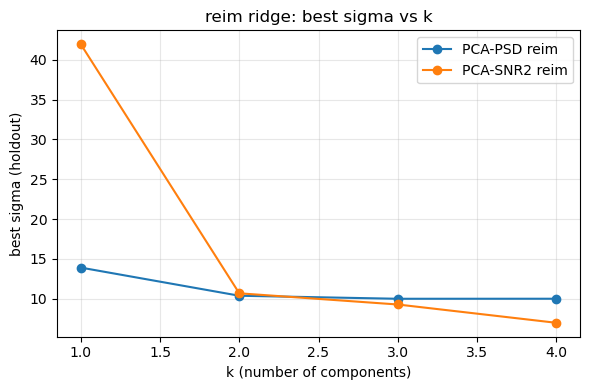

In [33]:
# Visualize reim ridge: best sigma vs k (holdout)
import numpy as np
import matplotlib.pyplot as plt

alphas = np.logspace(-8, 2, 11)
k_list = [1, 2, 3, 4]

def make_reim_features(coeff, k):
    c = coeff[:, :k]
    return np.column_stack([c.real, c.imag])

def standardize(train, val):
    mu = train.mean(axis=0)
    sig = train.std(axis=0)
    sig[sig == 0] = 1.0
    return (train - mu) / sig, (val - mu) / sig

def ridge_fit_predict(X_train, y_train, X_val, alpha):
    X1 = np.column_stack([X_train, np.ones(X_train.shape[0])])
    I = np.eye(X1.shape[1])
    I[-1, -1] = 0.0
    w = np.linalg.solve(X1.T @ X1 + alpha * I, X1.T @ y_train)
    y_est = np.column_stack([X_val, np.ones(X_val.shape[0])]) @ w
    return y_est

def best_sigma_by_k(coeff):
    best = []
    for k in k_list:
        X = make_reim_features(coeff, k)
        X_train = X[train_idx]
        X_val = X[val_idx]
        X_train, X_val = standardize(X_train, X_val)
        best_k = None
        for a in alphas:
            y_est = ridge_fit_predict(X_train, A_true_eval[train_idx], X_val, alpha=a)
            sigma, fwhm = resolution_from_truth(y_est, A_true_eval[val_idx])
            if best_k is None or sigma < best_k:
                best_k = sigma
        best.append(best_k)
    return best

sig_psd = best_sigma_by_k(coeff_psd)
sig_snr = best_sigma_by_k(coeff_snr)

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(k_list, sig_psd, marker='o', label='PCA-PSD reim')
ax.plot(k_list, sig_snr, marker='o', label='PCA-SNR2 reim')
ax.set_xlabel('k (number of components)')
ax.set_ylabel('best sigma (holdout)')
ax.set_title('reim ridge: best sigma vs k')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()
